In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Concatenate, ReLU
from tensorflow.keras.models import Model
import os
import numpy as np
from PIL import Image
import glob
import matplotlib.pyplot as plt


In [21]:
# Path to the folder containing the images
data_path = '/maps/train/'

# Function to load and preprocess images
def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize((512, 256))  # Ensure the image is the correct size
    image = np.array(image).astype(np.float32)  # Cast to float32
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Load all images
image_files = glob.glob(os.path.join(data_path, '*.jpg'))
all_images = np.array([load_image(file) for file in image_files])

# Split images into input (satellite) and target (map)
input_images = all_images[:, :, :256, :]  # Shape: (number_of_images, 256, 256, 3)
target_images = all_images[:, :, 256:, :]  # Shape: (number_of_images, 256, 256, 3)

# Split into training and validation sets
train_size = int(0.8 * len(input_images))
train_input_images = input_images[:train_size]
train_target_images = target_images[:train_size]
val_input_images = input_images[train_size:]
val_target_images = target_images[train_size:]

# Ensure the input shapes are correct
print(train_input_images.shape)
print(train_target_images.shape)

BATCH_SIZE = 1
# Create TensorFlow Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_images, train_target_images))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_input_images, val_target_images))
val_dataset = val_dataset.batch(BATCH_SIZE)


(876, 256, 256, 3)
(876, 256, 256, 3)


In [23]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (bs, 256, 256, 3)
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


In [24]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    down4 = downsample(512, 4)(down3)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer, padding='same')(down4)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [25]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss


In [45]:
class Pix2Pix(tf.keras.Model):
    def __init__(self, generator, discriminator, generator_optimizer, discriminator_optimizer, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    def compile(self, generator_loss, discriminator_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss

    def train_step(self, data):
        input_image, target = data
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = self.generator(input_image, training=True)
            disc_real_output = self.discriminator([input_image, target], training=True)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)
            gen_loss = self.generator_loss(disc_generated_output, gen_output, target)
            disc_loss = self.discriminator_loss(disc_real_output, disc_generated_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return {"gen_loss": gen_loss, "disc_loss": disc_loss}
    
    def call(self, inputs):
        return self.generator(inputs)


In [46]:
# Instantiate the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Instantiate the optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Instantiate the custom model
pix2pix_model = Pix2Pix(generator, discriminator, generator_optimizer, discriminator_optimizer)

# Compile the model
pix2pix_model.compile(
    generator_loss=generator_loss,
    discriminator_loss=discriminator_loss,
    loss='binary_crossentropy'  # Dummy loss
)


In [47]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch:02d}.weights.h5")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Restore the latest checkpoint if exists
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Callbacks for checkpointing
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_prefix,
        save_weights_only=True,
        save_freq='epoch'  # Save checkpoint at the end of every epoch
    )
]

# Fit the model with callbacks
pix2pix_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks)


Epoch 1/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - disc_loss: 0.9078 - gen_loss: 14.4174 - val_loss: 1.2102
Epoch 2/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - disc_loss: 0.8584 - gen_loss: 12.1662 - val_loss: 2.7199
Epoch 3/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - disc_loss: 0.7936 - gen_loss: 11.5862 - val_loss: 0.9941
Epoch 4/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - disc_loss: 0.8416 - gen_loss: 10.9847 - val_loss: 0.7165
Epoch 5/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - disc_loss: 0.8569 - gen_loss: 10.4270 - val_loss: 0.8077
Epoch 6/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - disc_loss: 0.8135 - gen_loss: 10.2966 - val_loss: 0.6459
Epoch 7/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - disc_loss: 0.7477 - gen_loss: 10.1857 - val_loss: 0.7054
Epoch 8/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - disc_loss: 0.6981 - gen_loss: 10.0928 - val_loss: 0.8020
Epoch 9/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - disc_loss: 0.6721 - gen_loss: 9

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7fd8dd3737e0>
Traceback (most recent call last):
  File "/usr/lib/python3.11/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd9e2b96e90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

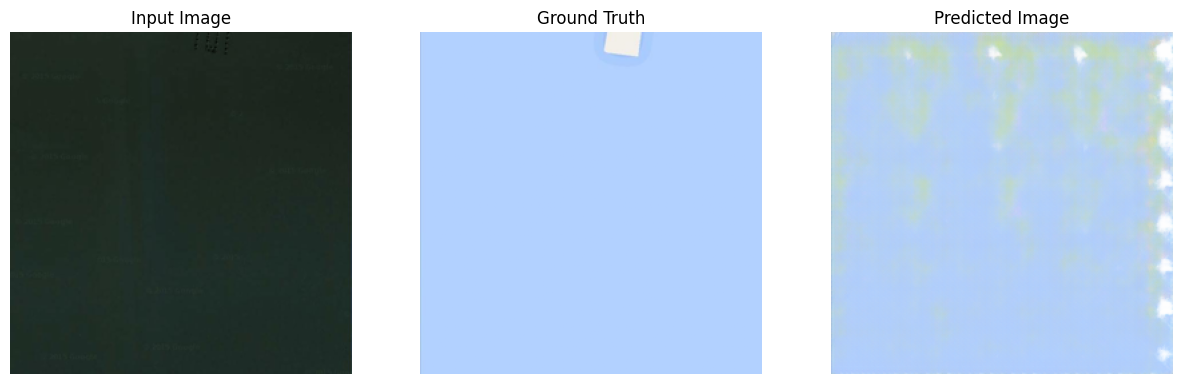

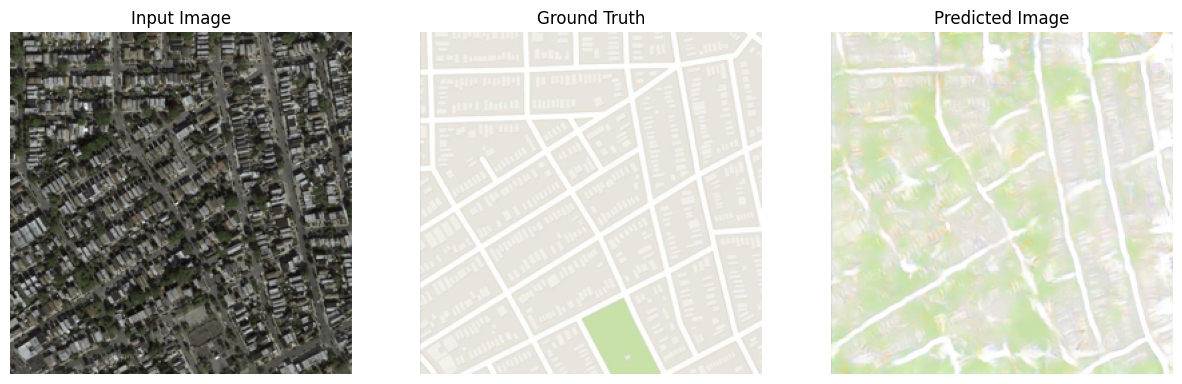

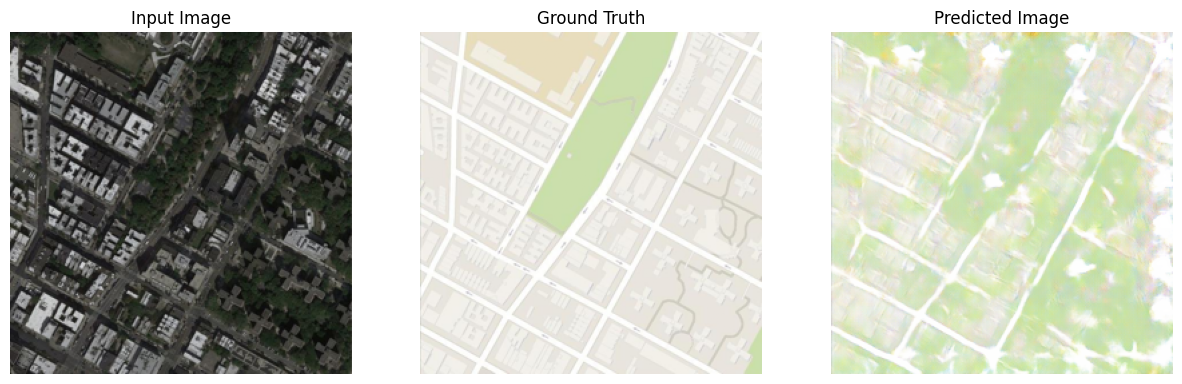

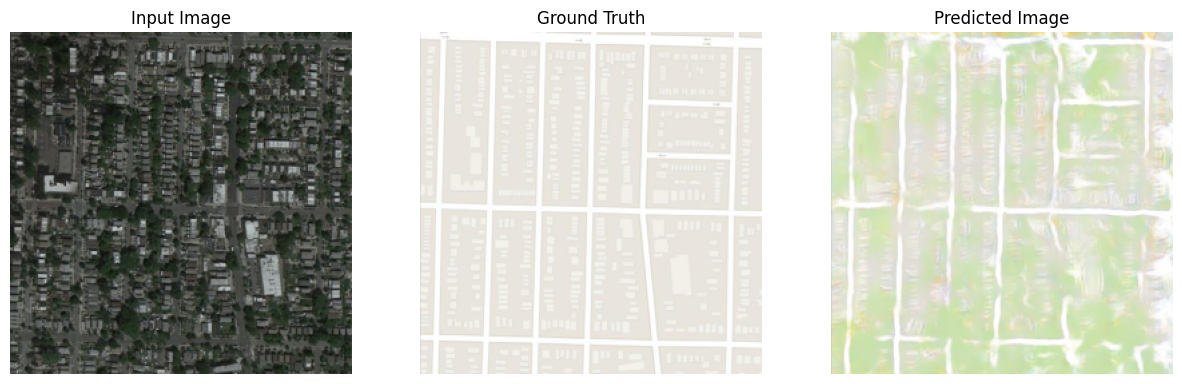

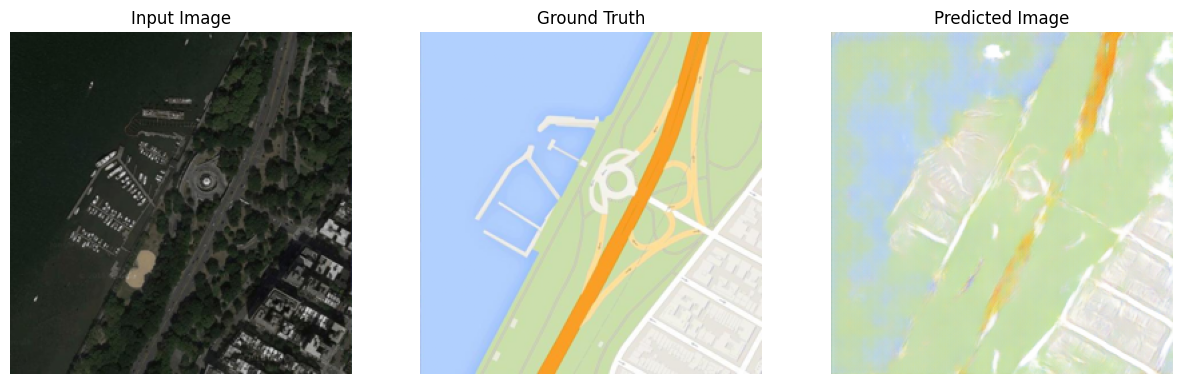

2024-06-27 04:30:51.400410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [48]:
import matplotlib.pyplot as plt

def generate_and_save_images(model, test_input, target, epoch):
    prediction = model(test_input, training=False)

    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values back to [0, 1]
        plt.imshow((display_list[i] + 1) / 2.0)
        plt.axis('off')
    plt.savefig(f'output_epoch_{epoch+1}.png')
    plt.show()

# Generate and save images from the validation dataset
for example_input, example_target in val_dataset.take(5):
    generate_and_save_images(pix2pix_model.generator, example_input, example_target, epoch=50)


In [15]:
# Restore the latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()

# Verify if the generator has been restored
if tf.train.latest_checkpoint(checkpoint_dir):
    print("Checkpoint restored from:", tf.train.latest_checkpoint(checkpoint_dir))
else:
    print("No checkpoint found.")


Checkpoint restored from: ./training_checkpoints/ckpt-5


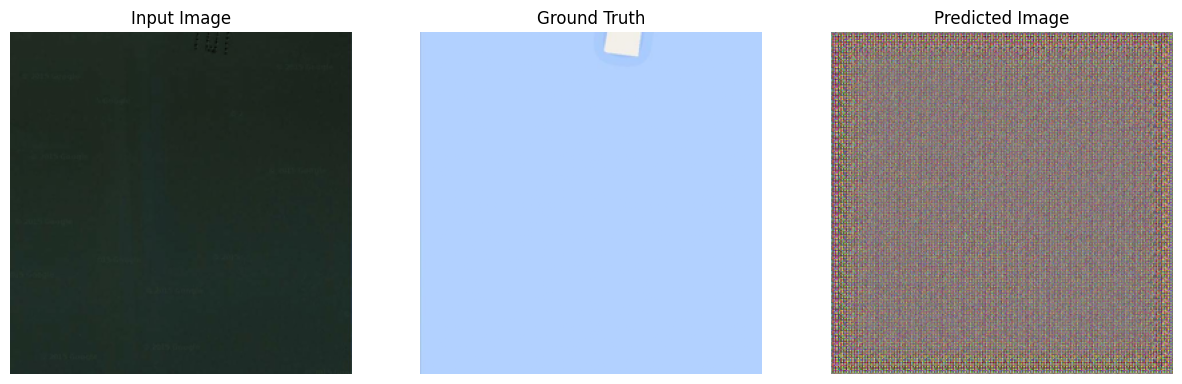

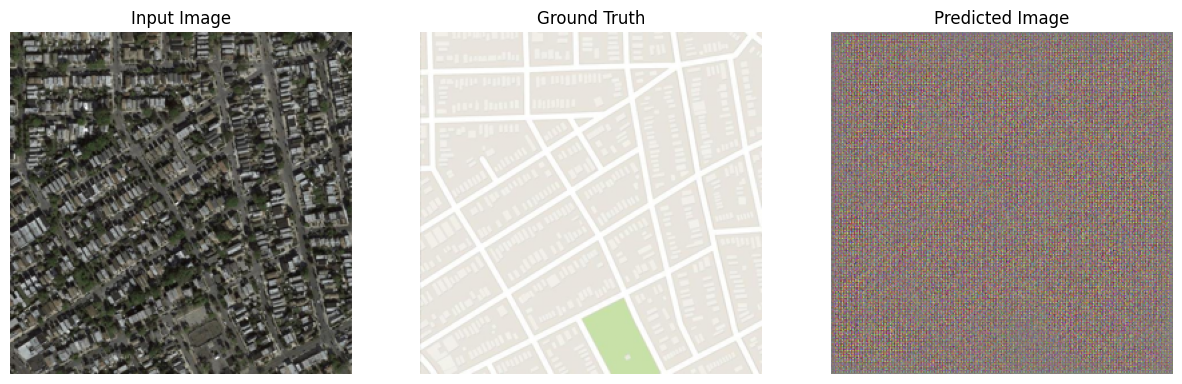

2024-06-27 03:40:33.421098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
import matplotlib.pyplot as plt

def generate_and_save_images(model, test_input, target, epoch):
    prediction = model(test_input, training=True)

    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values back to [0, 1]
        plt.imshow((display_list[i] + 1) / 2.0)
        plt.axis('off')
    plt.savefig(f'output_epoch_{epoch+1}.png')
    plt.show()

# Use the validation dataset to generate and print output images
for example_input, example_target in val_dataset.take(2):
    generate_and_save_images(generator, example_input, example_target, 0)
